# CCPi Iterative Reconstruction Algorithms

This notebook contains basic demo how to use CCPi reconstruction algorithms.
There are three main iterative reconstructions available in this package. they are
* Conjugate Gradient Least Squares (CGLS)* Maximum Likelihood Estimation Method (MLEM)* Simultaneous Iterative Reconstructive Technique (SIRT)
In addition to the above methods there are three more varients of CGLS available in this package. they are
* CGLS with Convolution* CGLS with Tikhonov regularization* CGLS with Total Variation Regularisation (TV)

In [1]:
from ccpi.reconstruction.parallelbeam import alg
import numpy
import h5py

Download demo data from github using urllib.request.

In [2]:
import urllib.request
urllib.request.urlretrieve("https://github.com/DiamondLightSource/Savu/blob/master/test_data/data/24737_fd.nxs?raw=true", "24737_fd.nxs")
# https://github.com/DiamondLightSource/Savu/blob/master/test_data/data/24737_fd.nxs?raw=true
#import wget
#wget.download("https://github.com/DiamondLightSource/Savu/blob/master/test_data/data/24737_fd.nxs?raw=true", "24737_fd.nxs")

('24737_fd.nxs', <http.client.HTTPMessage at 0x7fe75c888080>)

After imports one should load the dataset. The pre-processing, i.e. load the nexus (hdf5) file, extracting the angles and image data, scaling to 0-1 scalar range are done within the load_data function.

In [3]:
def load_data(filename):
    '''Load a dataset stored in a NeXuS file (HDF5)'''
    print ("Loading Data")
    nx = h5py.File(filename, "r")
    data = nx.get('entry1/tomo_entry/data/rotation_angle')
    angles = numpy.zeros(data.shape)
    data.read_direct(angles)
    print (angles)
    data = nx.get('entry1/tomo_entry/data/data')
    stack = numpy.zeros(data.shape)
    data.read_direct(stack)
    print (data.shape)
    print ("Data Loaded")
    # Normalize
    data = nx.get('entry1/tomo_entry/instrument/detector/image_key')
    itype = numpy.zeros(data.shape)
    data.read_direct(itype)
    # 2 is dark field
    darks = [stack[i] for i in range(len(itype)) if itype[i] == 2 ]
    dark = darks[0]
    for i in range(1, len(darks)):
        dark += darks[i]
    dark = dark / len(darks)
    # 1 is flat field
    flats = [stack[i] for i in range(len(itype)) if itype[i] == 1 ]
    flat = flats[0]
    for i in range(1, len(flats)):
        flat += flats[i]
    flat = flat / len(flats)
    # 0 is projection data
    proj = [stack[i] for i in range(len(itype)) if itype[i] == 0 ]
    angle_proj = [angles[i] for i in range(len(itype)) if itype[i] == 0 ]
    angle_proj = numpy.asarray (angle_proj)
    angle_proj = angle_proj.astype(numpy.float32)
    def normalize(projection, dark, flat, def_val=0.1):
        a = (projection - dark)
        b = (flat-dark)
        with numpy.errstate(divide='ignore', invalid='ignore'):
            c = numpy.true_divide( a, b )
            c[ ~ numpy.isfinite( c )] = def_val  # set to not zero if 0/0 
        return c
    norm = [normalize(projection, dark, flat) for projection in proj]
    norm = numpy.asarray (norm)
    norm = norm.astype(numpy.float32)
    return norm, angle_proj


In [4]:
filename = "24737_fd.nxs"
## TODO load_data is not defined - where it came from???
norm, angle_proj = load_data(filename)

Loading Data
[-88.2    -88.2    -88.2    -88.2    -88.2    -88.2    -88.2    -88.2    -88.2
 -88.2    -88.2    -86.2    -84.2001 -82.2    -80.2    -78.2    -76.1999
 -74.2    -72.1999 -70.2    -68.2    -66.2    -64.1999 -62.2    -60.2    -58.2
 -56.2    -54.2    -52.2    -50.2    -48.2    -46.2    -44.1999 -42.1999
 -40.2    -38.2    -36.1997 -34.2    -32.2    -30.2    -28.2    -26.2    -24.2
 -22.2    -20.2    -18.2    -16.2    -14.2    -12.2    -10.1999  -8.2     -6.2
  -4.1999  -2.2     -0.2      1.8      3.8001   5.8      7.8      9.8
  11.7999  13.8     15.7999  17.8     19.8     21.8     23.8     25.8     27.8
  29.8     31.8     33.8     35.8     37.8     39.8     41.8     43.7999
  45.8     47.8     49.8     51.8     53.8     55.8     57.8     59.8     61.8
  63.8     65.8     67.8001  69.8     71.8     73.8     75.8     77.8     79.8
  81.8     83.8     85.8     87.8     89.8     91.7999  91.8     91.8     91.8
  91.8     91.8     91.8     91.8     91.8     91.8     91.8   ]
(

Data can now be passed to the reconstruction algorithms.

In [5]:
## Data can now be passed to the reconstruction algorithms:
## CGLS, MLEM, SIRT, CGLS_CONV, CGLS_TIKHONOV, CGLS_TVregularization
# center of rotation
center_of_rotation = numpy.double(86.2)
# resolution
resolution = 1
# number of iterations
niterations = 15
# number of threads
threads = 3
#data are in log scale?
isPixelDataInLogScale = False


# CGLS
img_cgls = alg.cgls(norm, angle_proj, center_of_rotation , resolution ,
                    niterations, threads, isPixelDataInLogScale)
# MLEM
img_mlem = alg.mlem(norm, angle_proj,  center_of_rotation , resolution ,
                    niterations, threads, isPixelDataInLogScale)
# SIRT
img_sirt = alg.sirt(norm, angle_proj, center_of_rotation , resolution ,
                    niterations, threads, isPixelDataInLogScale)

# CGLS CONV
iteration_values1 = numpy.zeros((niterations,))
img_cgls_conv = alg.cgls_conv(norm, angle_proj, center_of_rotation ,
                              resolution ,
                              niterations , threads,
                              iteration_values1 , isPixelDataInLogScale)

#Regularization parameter
regularization = numpy.double(1e-3)

# CGLS TIKHONOV
iteration_values2 = numpy.zeros((niterations,))
img_cgls_tikhonov = alg.cgls_tikhonov(norm, angle_proj, center_of_rotation ,
                                      resolution , niterations, threads,
                                      regularization, iteration_values2 ,
                                      isPixelDataInLogScale)

# CGLS Total Variation Regularization
iteration_values3 = numpy.zeros((niterations,))
img_cgls_TVreg = alg.cgls_TVreg(norm, angle_proj, center_of_rotation ,
                                resolution ,  niterations, threads,
                                      regularization, iteration_values3,
                                      isPixelDataInLogScale)



One may want to compare the results of the reconstruction algorithms:

<IPython.core.display.Javascript object>


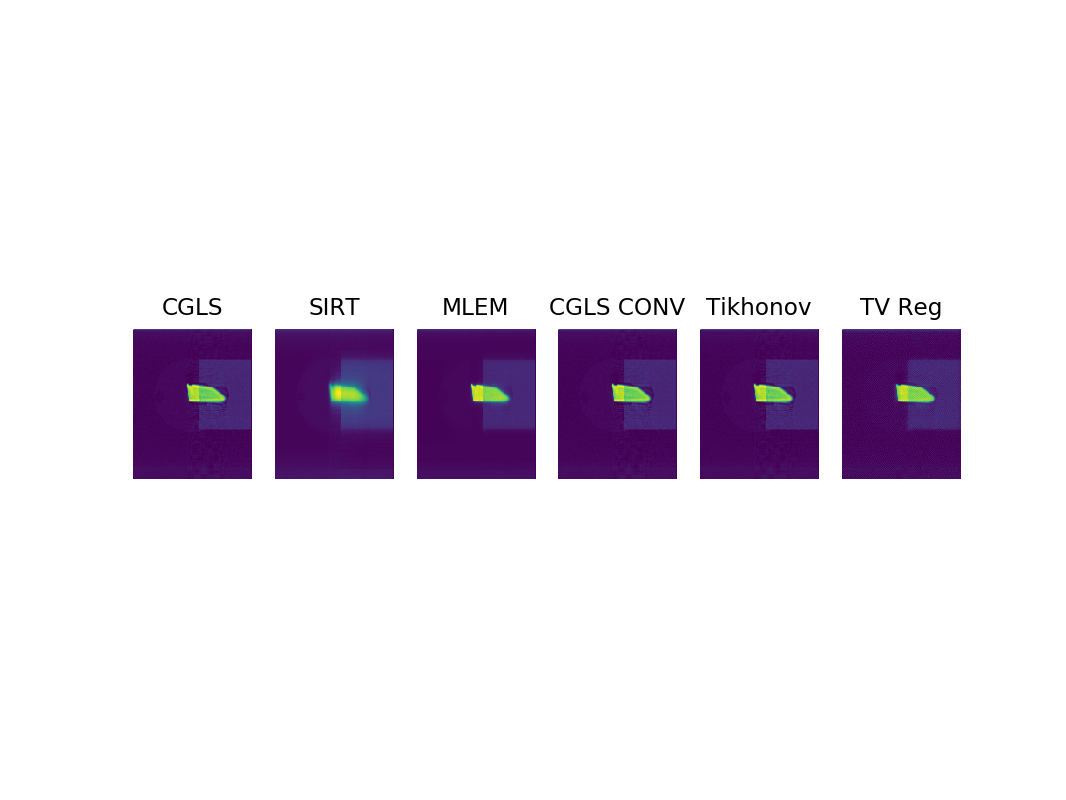

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
fs = 10
fig, ax = plt.subplots(1,6,sharey=True)
ax[0].imshow(img_cgls[80])
ax[0].axis('off')  # clear x- and y-axes
ax[0].set_title("CGLS" , fontsize = fs)

ax[1].imshow(img_sirt[80])
ax[1].axis('off')  # clear x- and y-axes
ax[1].set_title("SIRT" , fontsize = fs)

ax[2].imshow(img_mlem[80])
ax[2].axis('off')  # clear x- and y-axesplt.show()
ax[2].set_title("MLEM" , fontsize = fs)

ax[3].imshow(img_cgls_conv[80])
ax[3].axis('off')  # clear x- and y-axesplt.show()
ax[3].set_title("CGLS CONV" , fontsize = fs)

ax[4].imshow(img_cgls_tikhonov[80])
ax[4].axis('off')  # clear x- and y-axesplt.show()
ax[4].set_title("Tikhonov" , fontsize = fs)

ax[5].imshow(img_cgls_TVreg[80])
ax[5].axis('off')  # clear x- and y-axesplt.show()
ax[5].set_title("TV Reg" , fontsize = fs)
plt.show()